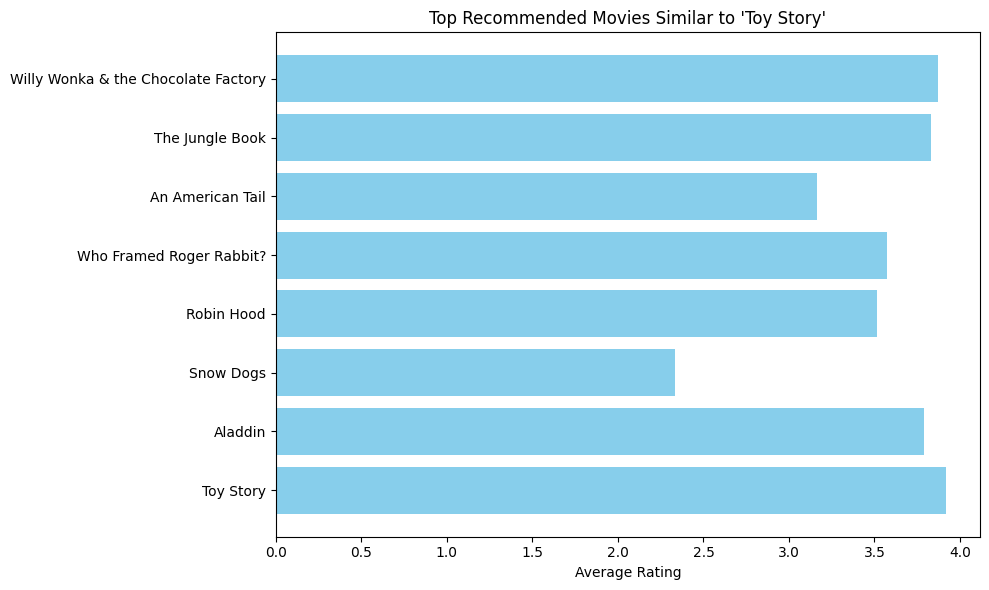

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import numpy as np
import faiss
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("machine_learning/cleaned_data.csv")
df["tag"] = df["tag"].fillna("")

# Genre columns
genre_cols = ['Action', 'Children', 'Comedy', 'Documentary', 'Horror', 'Romance', 'Sci-Fi']
genre_matrix = df[genre_cols]
genre_matrix_normalized = normalize(genre_matrix, axis=1)
genre_matrix_np = np.array(genre_matrix_normalized, dtype=np.float32)

# FAISS index
index = faiss.IndexFlatL2(genre_matrix_np.shape[1])
index.add(genre_matrix_np)

# Recommender function
def recommend_by_genre_faiss(movie_title, df, index, top_n=10):
    try:
        idx = df[df['title'].str.lower() == movie_title.lower()].index[0]
        movie_vector = genre_matrix_np[idx].reshape(1, -1)
        D, I = index.search(movie_vector, top_n + 1)
        recommended_titles = df.iloc[I[0][1:]][['title', 'avg_movie_rating']] if 'avg_movie_rating' in df.columns else df.iloc[I[0][1:]][['title']]
        return recommended_titles
    except IndexError:
        return "Movie not found. Please check the title."

# Input movie title (can have leading/trailing spaces, different cases)
input_movie = "Toy Story".strip().lower()

# Normalize title column for matching
df['title_normalized'] = df['title'].str.strip().str.lower()

# Check if movie exists
if input_movie in df['title_normalized'].values:
    recommendations = recommend_by_genre_faiss(input_movie, df, index)

    # Drop NaN ratings (if any)
    if isinstance(recommendations, pd.DataFrame) and 'avg_movie_rating' in recommendations.columns:
        recommendations = recommendations.dropna(subset=['avg_movie_rating'])

        # Visualize if still not empty
        if not recommendations.empty:
            plt.figure(figsize=(10, 6))
            plt.barh(recommendations['title'], recommendations['avg_movie_rating'], color='skyblue')
            plt.xlabel("Average Rating")
            plt.title(f"Top Recommended Movies Similar to '{input_movie.title()}'")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        else:
            print("Recommendations found, but no ratings available to plot.")
    else:
        print("Recommendations do not include 'avg_movie_rating'.")
else:
    print(f"Movie '{input_movie}' not found in dataset.")

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7829
           1       0.92      0.89      0.91     12339

    accuracy                           0.89     20168
   macro avg       0.88      0.89      0.88     20168
weighted avg       0.89      0.89      0.89     20168



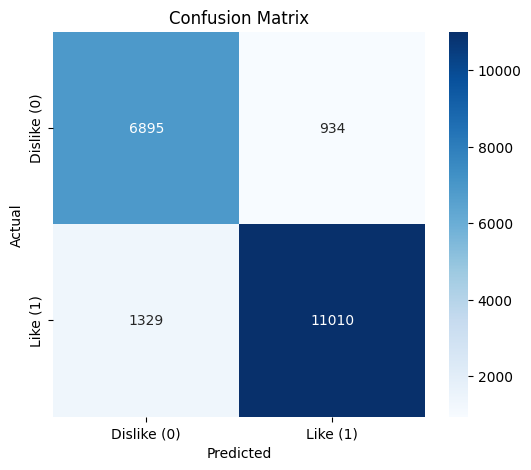

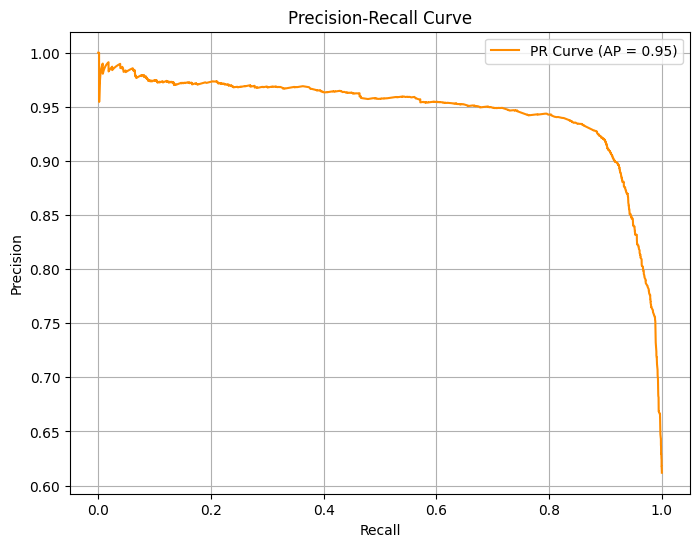


=== Movie Preference Predictor ===
Enter a movie title or ID to predict if you'll like it
(Type 'quit' to exit)


Movie: Toy Story (2016)
Prediction: 👍 LIKE
Confidence: 69%




In [ ]:
#convert text data(movie tags) into numerical features
from sklearn.feature_extraction.text import TfidfVectorizer
#machine learning model
from sklearn.ensemble import RandomForestClassifier
#model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
#Data handling, feature engineering
from scipy.sparse import hstack, csr_matrix
#hstack: combines features, stacks sparse matrices
#csr_matrix: convert dense arrays to sparse format
from sklearn.preprocessing import StandardScaler
#standardize features by removing mean and scaling to unit variance
#data processing and visualization
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Load data
df = pd.read_csv("machine_learning/cleaned_data.csv")

# Convert timestamp to year
df["year"] = pd.to_datetime(df["timestamp"], unit='s').dt.year

# Create movie lookup first
movie_lookup = {}
for _, row in df.iterrows():
    movie_lookup[row['movieId']] = row
    movie_lookup[row['title'].lower()] = row

# Prepare label
df["like"] = df["implicit_ratings"]  # already binary

# Define genre columns
genre_cols = ['Action', 'Children', 'Comedy', 'Documentary', 'Horror', 'Romance', 'Sci-Fi']
genre_features = df[genre_cols]

# 4. Feature Engineering Section (replace your current feature code with this)
# --------------------------------------------------
tfidf = TfidfVectorizer(max_features=500)
tag_features = tfidf.fit_transform(df["tag"].fillna(""))
rating_feature = df[["normalized_rating"]]

# Create tag count feature
df["tag_count"] = df["tag"].fillna("").apply(lambda x: len(x.split()))
tag_count_feature = df[["tag_count"]]

# Create decade features
df["year"] = pd.to_datetime(df["timestamp"], unit='s').dt.year
df["decade"] = (df["year"] // 10) * 10
decade_features = pd.get_dummies(df["decade"], prefix="decade")
decade_columns = decade_features.columns.tolist()  # Save for prediction

# 4. Prepare properly named feature DataFrames
tag_features = tfidf.fit_transform(df["tag"].fillna(""))  # Keep as sparse matrix

genre_df = genre_features.reset_index(drop=True)  # Genre features keep original names
num_df = pd.concat([
    df[["normalized_rating"]],
    df["tag"].fillna("").apply(lambda x: len(x.split())).rename("tag_count")  # Create tag count
], axis=1)  # Numerical features
scaler = StandardScaler()
num_features_scaled = scaler.fit_transform(num_df)  # Fit and transform numerical features
decade_df = decade_features.reset_index(drop=True)  # Decade dummy features

# 5. Combine all features
X = hstack([
    tag_features,                       # TF-IDF features(500 dimensions)
    csr_matrix(df[genre_cols].values),  # Genre features (7 dimensions)
    csr_matrix(num_features_scaled),  # Scaled numerical features (2)
    csr_matrix(decade_features.values)  # Decade features
])
#csr_matrix convert dense arrays to sparse format

scaler = StandardScaler().fit(num_df.values)  # Fit only on numerical features

# Process features
y = df["like"]
# --------------------------------------------------

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#20% data is used for testing
# Train model
model = RandomForestClassifier(
    n_estimators=100,           #number of trees in the forest
    max_depth=10,               #maximum depth of each tree
    class_weight="balanced",    #adjusts for imbalanced classes
    random_state=42,            #ensures reproducibility
    n_jobs=-1                   #uses all CPU cores for parallel processing
)
model.fit(X_train, y_train)

def simple_predict(decade_columns):
    print("\n=== Movie Preference Predictor ===")
    print("Enter a movie title or ID to predict if you'll like it")
    print("(Type 'quit' to exit)\n")

    while True:
        user_input = input("Enter movie title/ID: ").strip()

        if user_input.lower() == 'quit':
            break

        # Find the movie
        movie = None
        try:
            if user_input.isdigit():
                movie = movie_lookup.get(int(user_input))
            if movie is None:
                movie = movie_lookup.get(user_input.lower())
        except ValueError:
            pass

        if movie is None:
            print("Movie not found. Try again or check your input.")
            continue

        try:
            # 1. Tag features
            movie_tag = str(movie['tag']) if pd.notna(movie['tag']) else ""
            tag_features = tfidf.transform([movie_tag])

            # 2. Genre features
            genre_features = np.array([movie[col] for col in genre_cols], dtype='float32').reshape(1, -1)

            # 3. Decade features - use the saved columns
            movie_year = int(movie.get('year', 2000))
            decade = (movie_year // 10) * 10
            decade_features = pd.DataFrame(0, index=[0], columns=decade_columns)
            decade_col = f"decade_{decade}"
            if decade_col in decade_features.columns:
                decade_features[decade_col] = 1

            # 4. Numerical features
            numerical_features = scaler.transform([[
              float(movie.get('normalized_rating', df['normalized_rating'].median())),
              float(len(movie_tag.split()) if movie_tag else 0)
            ]])

            # Combine features
            X = hstack([
                tag_features,
                csr_matrix(genre_features),
                csr_matrix(numerical_features),
                csr_matrix(decade_features.values)
            ])

            # Make prediction
            pred = model.predict(X)[0]
            proba = model.predict_proba(X)[0][1]

            print(f"\nMovie: {movie['title']} ({movie_year})")
            print(f"Prediction: {'👍 LIKE' if pred == 1 else '👎 DISLIKE'}")
            print(f"Confidence: {proba:.0%}")
            print("\n" + "="*40 + "\n")

        except Exception as e:
            print(f"Error making prediction: {str(e)}")
            continue

# Evaluation code # Generate predictions and print classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Dislike (0)', 'Like (1)']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate probabilities for PR curve
y_prob = model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange',
         label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)  # Optional: Add grid for readability
plt.show()


simple_predict(decade_columns=decade_columns)

In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving cleaned_data.csv to cleaned_data.csv


In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 13.3 MB/s eta 0:00:00
